# Adding TNCs

The purpose of this notebook is to illustrate the steps to add a new mode - Transportation Network Companies (or Ride Hailing) - to ActivitySim.  This notebook assumes users are familiar with the [Getting Started](getting_started.ipynb) notebook.  The basic steps are as follows:

  - Update the tour and trip mode choice model settings yaml file to include the mode
  - Update the tour and trip mode choice model expression files to include the mode and the utility expressions
  - Update the tour and trip mode choice model coefficients files to include any additional coefficients
  - Update the tour and trip mode choice model pre-processor annotation files to include any additional chooser data processing
  - Update the tour and trip mode choice model settings yaml file to include any additional constants to be referenced in the expressions
  - Run the model, summarize results to confirm the results, and make any necessary revisions to fix errors and/or calibrate the results
  
This notebook assumes you have run the example model.  

## Specify an example model run for illustration

In [2]:
example_dir = "example/"

## Load libraries

In [10]:
import os
import pandas as pd
import openmatrix as omx
import yaml
import glob

import matplotlib.pyplot as plt # !pip install matplotlib # for charts
import geopandas as gpd # !conda install geopandas # for making maps
import descartes # !conda install descartes # for making maps

pd.set_option("display.max_rows", None)

## Matplot Default Chart Settings

In [12]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,10)

## Update the tour and trip mode choice model settings yaml file to include the mode

The **NESTS** setting in the tour and trip mode choice model defines the available modes.  The RIDEHAIL alternative was added with the following alternatives - TAXI, TNC_SINGLE (single rider), and TNC_SHARED (2+ riders).  The coef_nest_RIDEHAIL was added to the relevant coefficient file, as discussed later.  The example below illustrates the tour mode choice yaml file.

In [3]:
with open(example_dir + 'configs/tour_mode_choice.yaml') as file:
    file_contents = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(file_contents))

COEFFICIENTS: tour_mode_choice_coeffs.csv
COEFFICIENT_TEMPLATE: tour_mode_choice_coeffs_template.csv
CONSTANTS:
  TNC_shared_IVTFactor: 1.5
  TNC_shared_baseFare: 2.2
  TNC_shared_costMinimum: 3.0
  TNC_shared_costPerMile: 0.53
  TNC_shared_costPerMinute: 0.1
  TNC_shared_waitTime_mean:
    1: 5.0
    2: 8.0
    3: 11.0
    4: 15.0
    5: 15.0
  TNC_shared_waitTime_sd:
    1: 0
    2: 0
    3: 0
    4: 0
    5: 0
  TNC_single_baseFare: 2.2
  TNC_single_costMinimum: 7.2
  TNC_single_costPerMile: 1.33
  TNC_single_costPerMinute: 0.24
  TNC_single_waitTime_mean:
    1: 3.0
    2: 6.3
    3: 8.4
    4: 8.5
    5: 10.3
  TNC_single_waitTime_sd:
    1: 0
    2: 0
    3: 0
    4: 0
    5: 0
  Taxi_baseFare: 2.2
  Taxi_costPerMile: 2.3
  Taxi_costPerMinute: 0.1
  Taxi_waitTime_mean:
    1: 5.5
    2: 9.5
    3: 13.3
    4: 17.3
    5: 26.5
  Taxi_waitTime_sd:
    1: 0
    2: 0
    3: 0
    4: 0
    5: 0
  bikeSpeed: 12.0
  bikeThresh: 6.0
  biketimelong_multiplier: 20
  biketimeshort_multiplie

## Update the tour and trip mode choice model expression files to include the mode and the utility expressions

The next step is to add the modes to the expressions file and then add expressions to describe the mode utilities.  As shown below, columns were added for each new alternative in the mode choice file and rows for each relevant expression for each mode.  Refer to the original CSV file for the entire expressions since they are truncated in the output below. The tour and trip mode choice models make use of coefficient files, which are discussed next.  The tour and trip mode choice models may also depend on submodel annotation preprocessors, which are discussed afterwards.

In [4]:
tour_mode_choice_expressions = pd.read_csv(example_dir + 'configs/tour_mode_choice.csv')

row_selector = (~tour_mode_choice_expressions.TAXI.isna() | ~tour_mode_choice_expressions.TNC_SINGLE.isna() | ~tour_mode_choice_expressions.TNC_SHARED.isna())

tour_mode_choice_expressions[row_selector]


,Label,Description,Expression,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,...,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED
254,util_Taxi_In_vehicle_time,Taxi - In-vehicle time,@(odt_skims['HOV2TOLL_TIME'] + dot_skims['HOV2...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,coef_ivt,NaN,NaN
256,util_Taxi_Wait_time,Taxi - Wait time,@1.5 * df.totalWaitTaxi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,coef_ivt,NaN,NaN
257,util_Taxi_Tolls,Taxi - Tolls,@ivt_cost_multiplier * df.ivot * (odt_skims['H...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,coef_ivt,NaN,NaN
258,util_Taxi_Bridge_toll,Taxi - Bridge toll,@ivt_cost_multiplier * df.ivot * (odt_skims['H...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,coef_ivt,NaN,NaN
259,util_Taxi_Fare,Taxi - Fare,@ivt_cost_multiplier * df.ivot * (Taxi_baseFar...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,coef_ivt,NaN,NaN
261,util_TNC_Single_In_vehicle_time,TNC Single - In-vehicle time,@(odt_skims['HOV2TOLL_TIME'] + dot_skims['HOV2...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,coef_ivt,NaN
262,util_TNC_Single_Wait_time,TNC Single - Wait time,@1.5 * df.totalWaitSingleTNC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,coef_ivt,NaN
263,util_TNC_Single_Tolls,TNC Single - Tolls,@ivt_cost_multiplier * df.ivot * (odt_skims['H...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,coef_ivt,NaN
264,util_TNC_Single_Bridge_toll,TNC Single - Bridge toll,@ivt_cost_multiplier * df.ivot * (odt_skims['H...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,coef_ivt,NaN
265,util_TNC_Single_Cost,TNC Single - Cost,@ivt_cost_multiplier * df.ivot * np.maximum(TN...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,coef_ivt,NaN


## Update the tour and trip mode choice model coefficients files to include any additional coefficients

As shown below for tour mode choice, several coefficients and/or constants were added when adding TNCs.  Example additional coefficients are the ridehail nesting coefficient and calibration constants by mode, auto sufficiency, and purpose.

In [5]:
tour_mode_choice_coefficients = pd.read_csv(example_dir + 'configs/tour_mode_choice_coeffs.csv')

tour_mode_choice_coefficients

,coefficient_name,value,constrain
0,coef_nest_root,1.000000,T
1,coef_nest_AUTO,0.720000,T
2,coef_nest_AUTO_DRIVEALONE,0.350000,T
3,coef_nest_AUTO_SHAREDRIDE2,0.350000,T
4,coef_nest_AUTO_SHAREDRIDE3,0.350000,T
5,coef_nest_NONMOTORIZED,0.720000,T
6,coef_nest_TRANSIT,0.720000,T
7,coef_nest_TRANSIT_WALKACCESS,0.500000,T
8,coef_nest_TRANSIT_DRIVEACCESS,0.500000,T
9,coef_nest_RIDEHAIL,0.360000,T


## Update the tour and trip mode choice model pre-processor annotation files to include any additional chooser data processing

The mode choice models also make use of chooser annotation preprocessors if needed.  As shown below, adding TNCs meant calculating the **origin_zone_singleTNC_wait_time_mean** variable for each chooser tour origin zone.  This was done by first calculating the origin zone density and density bin and then looking up the wait time mean for the origin zone from the tour mode choice settings yaml file constants.  The constants are discussed in more detail later.  

In [6]:
tour_mode_choice_preprocessor = pd.read_csv(example_dir + 'configs/tour_mode_choice_annotate_choosers_preprocessor.csv')

tour_mode_choice_preprocessor

,Description,Target,Expression
0,#,NaN,NaN
1,local,_DF_IS_TOUR,'tour_type' in df.columns
2,NaN,number_of_participants,df.number_of_participants if _DF_IS_TOUR else 1
3,NaN,is_joint,(df.tour_category=='joint') if _DF_IS_TOUR els...
4,#,NaN,NaN
5,local,_HAVE_PARENT_TOURS,'parent_tour_id' in df.columns
6,NaN,_parent_tour_mode,"reindex(tours.tour_mode, df.parent_tour_id) if..."
7,NaN,work_tour_is_drive,"_parent_tour_mode.isin(['DRIVEALONEFREE','DRIV..."
8,NaN,work_tour_is_bike,_parent_tour_mode=='BIKE'
9,NaN,work_tour_is_SOV,"_parent_tour_mode.isin(['DRIVEALONEFREE','DRIV..."


## Update the tour and trip mode choice model settings yaml file to include any additional constants to be referenced in the expressions

Additional constants can be defined in the tour and trip mode choice submodel settings yaml file and then referenced in the expression files.  The following example illustrates the **CONSTANTS** used for the additional TNC modes.

In [7]:
with open(example_dir + 'configs/tour_mode_choice.yaml') as file:
    file_contents = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(file_contents))

COEFFICIENTS: tour_mode_choice_coeffs.csv
COEFFICIENT_TEMPLATE: tour_mode_choice_coeffs_template.csv
CONSTANTS:
  TNC_shared_IVTFactor: 1.5
  TNC_shared_baseFare: 2.2
  TNC_shared_costMinimum: 3.0
  TNC_shared_costPerMile: 0.53
  TNC_shared_costPerMinute: 0.1
  TNC_shared_waitTime_mean:
    1: 5.0
    2: 8.0
    3: 11.0
    4: 15.0
    5: 15.0
  TNC_shared_waitTime_sd:
    1: 0
    2: 0
    3: 0
    4: 0
    5: 0
  TNC_single_baseFare: 2.2
  TNC_single_costMinimum: 7.2
  TNC_single_costPerMile: 1.33
  TNC_single_costPerMinute: 0.24
  TNC_single_waitTime_mean:
    1: 3.0
    2: 6.3
    3: 8.4
    4: 8.5
    5: 10.3
  TNC_single_waitTime_sd:
    1: 0
    2: 0
    3: 0
    4: 0
    5: 0
  Taxi_baseFare: 2.2
  Taxi_costPerMile: 2.3
  Taxi_costPerMinute: 0.1
  Taxi_waitTime_mean:
    1: 5.5
    2: 9.5
    3: 13.3
    4: 17.3
    5: 26.5
  Taxi_waitTime_sd:
    1: 0
    2: 0
    3: 0
    4: 0
    5: 0
  bikeSpeed: 12.0
  bikeThresh: 6.0
  biketimelong_multiplier: 20
  biketimeshort_multiplie

## Run the model, summarize outputs to confirm the results, and make any necessary revisions to fix errors and/or calibrate the results

The final step is to run the model, summarize outputs to confirm the results, and make any necessary revisions to fix errors and/or calibrate the results.  This entire sequence of steps to add a new mode is likely iterative as issues are identified and then fixed and the model re-run and results re-summarized until complete.

### Tours by mode

In [21]:
tours = pd.read_csv(example_dir + 'output/final_tours.csv')

tour_mode = tours.groupby(["tour_mode", "tour_category"]).count()["household_id"].reset_index()
tour_mode = tour_mode.pivot_table(index="tour_mode", columns="tour_category", fill_value=0)['household_id']
tour_mode

tour_category,atwork,joint,mandatory,non_mandatory
tour_mode,,,,
BIKE,0,0,4,2
DRIVEALONEFREE,0,0,3,5
SHARED2FREE,0,1,1,1
SHARED3FREE,0,0,3,1
TAXI,0,0,0,5
TNC_SINGLE,0,0,6,9
WALK,8,2,32,45
WALK_HVY,0,0,4,1
WALK_LOC,0,0,24,12


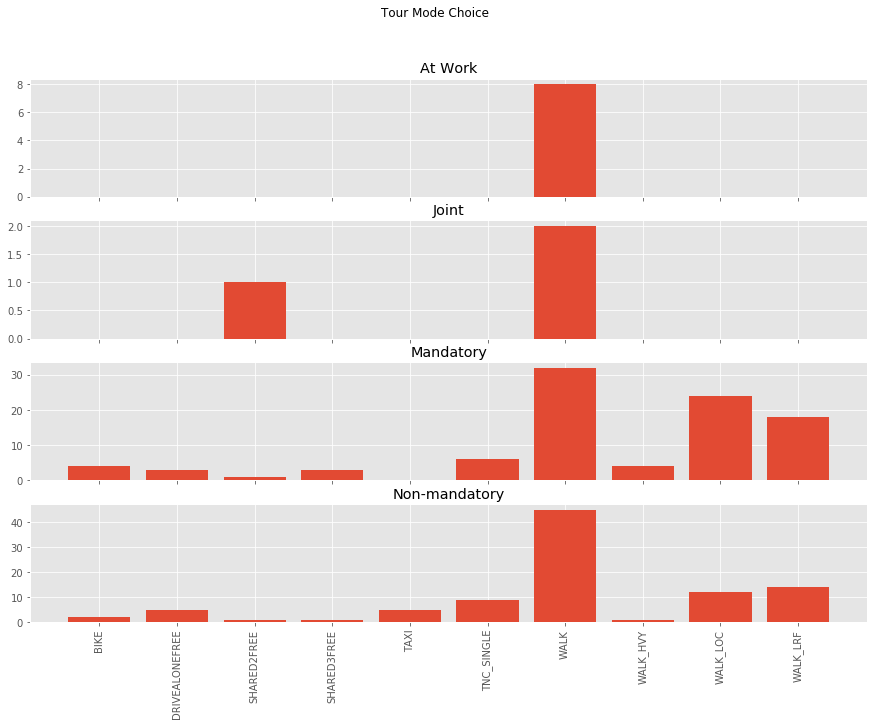

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
fig.suptitle('Tour Mode Choice')
ax1.bar(tour_mode.index, tour_mode['atwork'])
ax1.set_title('At Work')
ax2.bar(tour_mode.index, tour_mode['joint'])
ax2.set_title('Joint')
ax3.bar(tour_mode.index, tour_mode['mandatory'])
ax3.set_title('Mandatory')
ax4.bar(tour_mode.index, tour_mode['non_mandatory'])
ax4.set_title('Non-mandatory')
_ = plt.xticks(rotation='vertical')

### TNC tours by time-of-day

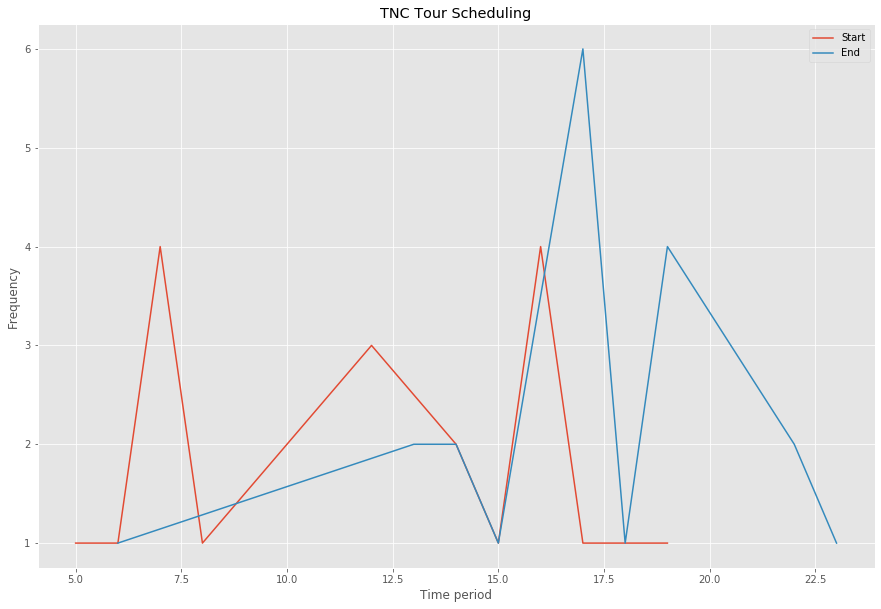

In [25]:
row_selector = ((tours.tour_mode == "TAXI") | (tours.tour_mode == "TNC_SINGLE") | (tours.tour_mode == "TNC_SHARED"))
tdd = tours[row_selector]
tdd = tdd.groupby(["start", "end"]).count()["household_id"].reset_index()
tdd = tdd.pivot_table(index="start", columns="end", fill_value=0)["household_id"]

plt.plot(tdd.sum(axis=1), label='Start')
plt.plot(tdd.sum(axis=0), label='End')
plt.title('TNC Tour Scheduling')
plt.ylabel('Frequency')
plt.xlabel('Time period')
_ = plt.legend(loc='best')

### TNC trips by origin zone

In [40]:
SHAPE_FILE = os.path.join('zone_shapefile', 'bayarea_rtaz1454_rev1.shp')
SHAPES = gpd.read_file(SHAPE_FILE)

c:\programdata\anaconda3\envs\asimtest\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


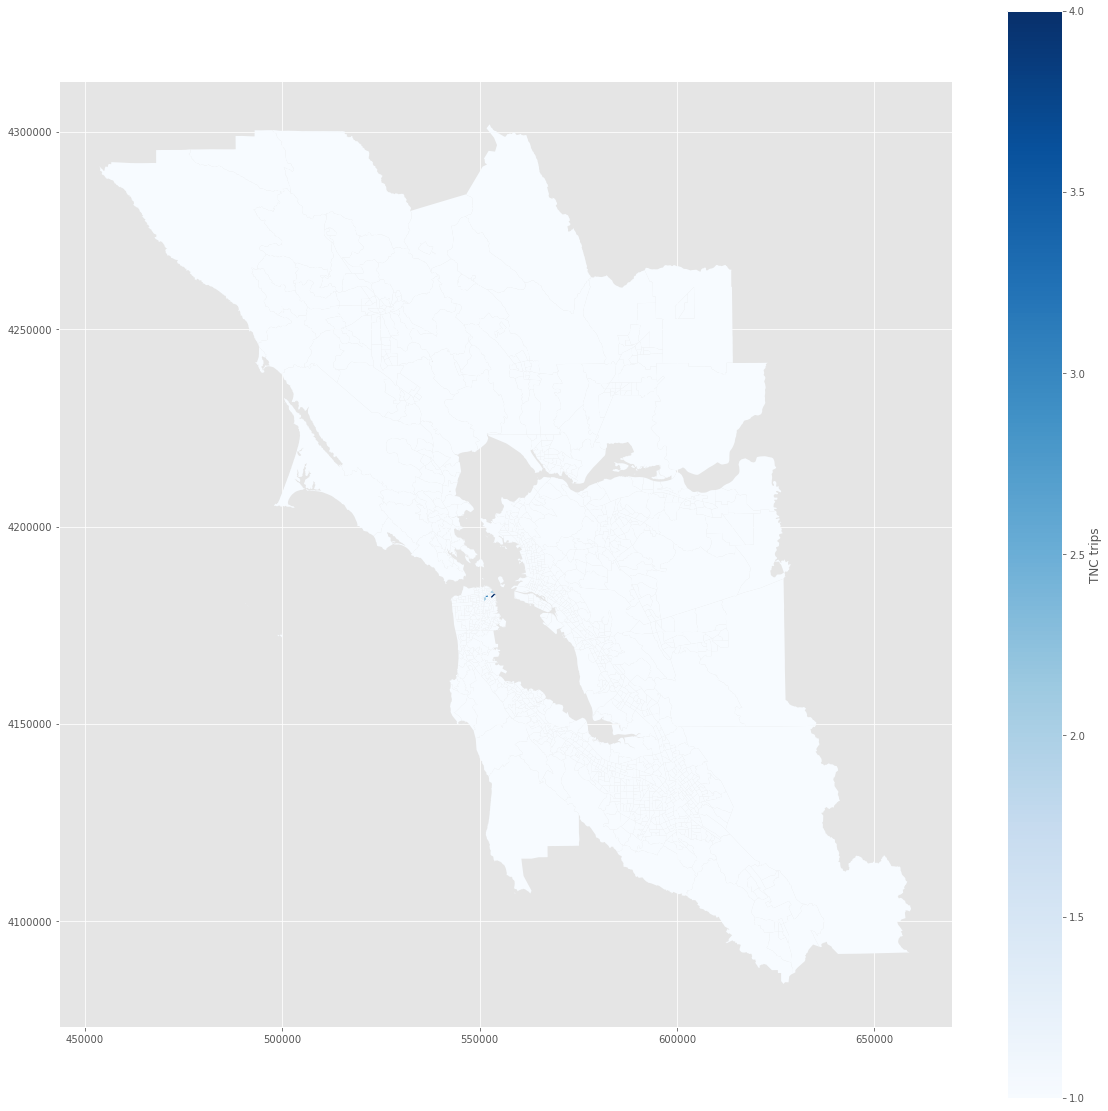

In [41]:
tours_by_zone = tours[row_selector].groupby(["origin", "tour_mode"]).count()
tnc_shapes = SHAPES.merge(tours_by_zone.reset_index(), how='left', left_on='TAZ1454', right_on='origin')
tnc_shapes.plot(column='tour_id', cmap='Blues',
                 legend=True,
                 legend_kwds={'label': "TNC trips"},
                 figsize=(20,20))